In [29]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt

## Sequential learning
Let us consider a scenario when the data comes to us in chunks. For instance, we observe new user sessions each day; or, alternatively, from time to time a new portion of a dataset is labelled by humans.

How can we update our current model to account for the incoming chunk? One way is disregard the existing model, add the new chunk to the earlier available dataset, and learn a new model from scratch. However, sometimes that approach is not cost-effective, and we look for a way to quickly update the existing model. How can we do that? Easy, Laplace approximation to the rescue.


We can think of that in a Bayesian setting: as a result of earlier learning, we obtained a Gaussian approximation $p_{old}(\theta)$ for the parameter $\theta$. The next step is to update this distribution given a new evidence.
$$
p(\theta) \propto p_{old}(\theta) P(\mathbb{D}_{new} | \theta)
$$
Taking logarithms of the both parts, we get
$$
log P(\theta) =  log P(\theta_{old}) + log P(\mathbb{D}_{new} | \theta)
$$
Maximizing posterior w.r.t. $\theta$,
$$
\hat \theta_{new} = argmax_{\theta} L_{new} = argmax_{\theta} ~ log P(\theta_{old}) + log P(\mathbb{D}_{new} | \theta) = 
argmax_{\theta} \left[ \frac{1}{2}(\theta - \hat \theta)^T \mathbb{H}_d (\theta - \hat \theta) + log P(\mathbb{D}_{new} | \theta) \right]
$$
By optimizing this equation numerically, we can find the updated model $\theta_{new}$. Furthermore, we find can find the Laplace approximation of the posterior by analysing second-order derivatives around the optimum $\hat \theta_{new}$:
$$
log P(\theta) \sim const + \frac{1}{2}(\theta - \hat \theta_{new})^T \left[ \nabla \nabla_ {\theta=\hat \theta_{new}} L_{new} \right]  (\theta - \hat \theta_{new})
$$
This time, $\nabla \nabla_ {\theta=\hat \theta_{new}} L_{new} $ would be as follows:
$$
\nabla \nabla_ {\theta=\hat \theta_{new}} L_{new} = \mathbb{H}_d + \nabla \nabla_ {\theta=\hat \theta_{new}} log P(\mathbb{D}_{new} | \theta)
$$


In an alternative point of view, we have a quadratic approximation of the loss on the "old" dataset, and can just optimize it jointly with a log-likelihood on the new incoming chunk.
$$
L_{new} = const + \frac{1}{2}(\theta - \hat \theta)^T \mathbb{H} (\theta - \hat \theta) + log P(\mathbb{D}_{new} | \theta)
$$
$$
\hat \theta_{new} = argmax ~ L_{new}
$$
and then we can replace this joint loss (on the incoming data and the surrogate representative of the loss on the "old" dataset) by a new quadratic surrogate, so that it can be used later.

$$
L_{new}(\theta) \approx L_{new}(\hat \theta_{new}) + \frac{1}{2}(\theta - \hat \theta_{new})^T \left[ \nabla \nabla_ {\theta=\hat \theta_{new}} L_{new} \right](\theta - \hat \theta_{new})
$$
As earlier, we have
$$
\nabla \nabla_ {\theta=\hat \theta_{new}} L_{new} = \mathbb{H}_d + \nabla \nabla_ {\theta=\hat \theta_{new}} log P(\mathbb{D}_{new} | \theta)
$$

We will illustrate the sequential learning approach in a following experiment. Let's take the MNIST dataset and split its training subset in 10 equal parts. After that, we will sequentially learn on them and control how the loss on the validation dataset is behaving. As baselines we will consider two set-ups. Firstly, we will learn a single model using the whole training dataset. That baseline would provide us with an upper-bound for the performance. Secondly, we will sequentally train a single model on these 10 parts, but without using the earlier output as a prior.

In [24]:
from model import LaplacedModel, get_learning_curve
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
sequential_tasks = 10

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [31]:
model_laplaced = LaplacedModel(4, 0.0, 1.0, True)
laplaced_loss_curve = get_learning_curve(model_laplaced, mnist.train, mnist.test, sequential_tasks)

learning task # 0
validation loss: [0.57260001]
learning task # 1
validation loss: [0.70190001]
learning task # 2
validation loss: [0.7683]
learning task # 3
validation loss: [0.8039]
learning task # 4
validation loss: [0.8143]
learning task # 5
validation loss: [0.83139998]
learning task # 6
validation loss: [0.82880002]
learning task # 7
validation loss: [0.83759999]
learning task # 8
validation loss: [0.8387]
learning task # 9
validation loss: [0.84320003]


In [32]:
print laplaced_loss_curve

[[0.57260001], [0.70190001], [0.7683], [0.8039], [0.8143], [0.83139998], [0.82880002], [0.83759999], [0.8387], [0.84320003]]


In [33]:
model_naive = LaplacedModel(4, 0.0, 1.0, False)
naive_loss_curve = get_learning_curve(model_naive, mnist.train, mnist.test, sequential_tasks)

learning task # 0
validation loss: [0.57260001]
learning task # 1
validation loss: [0.58840001]
learning task # 2
validation loss: [0.61210001]
learning task # 3
validation loss: [0.59939998]
learning task # 4
validation loss: [0.58579999]
learning task # 5
validation loss: [0.6081]
learning task # 6
validation loss: [0.6103]
learning task # 7
validation loss: [0.63]
learning task # 8
validation loss: [0.57090002]
learning task # 9
validation loss: [0.60110003]


In [34]:
print naive_loss_curve

[[0.57260001], [0.58840001], [0.61210001], [0.59939998], [0.58579999], [0.6081], [0.6103], [0.63], [0.57090002], [0.60110003]]


In [35]:
upper_bound_model = LaplacedModel(4, 0.0, 1.0, False)
upper_bound_curve = upper_bound_model.learn_new_task(mnist.train, mnist.test)

0.6985
0.863
0.8735
0.888
0.8875
0.8975
0.9125
0.92
0.909
0.9145


In [36]:
print upper_bound_curve

[0.92650002]


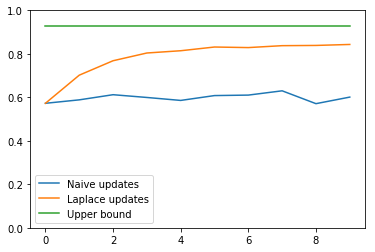

In [37]:
plt.plot(naive_loss_curve, label='Naive updates')
plt.plot(laplaced_loss_curve, label='Laplace updates')
plt.plot([upper_bound_curve for _ in naive_loss_curve], label='Upper bound')
plt.ylim([0, 1])

plt.legend()

While the updated learning is not as good as the upper bound, but we see it's way better than the naive approach. Hence, it's a nice alternative when the it is infeasible/too expensive to learn on the entire dataset.